## <h1><center>SNOW MONITORING WITH DATA CUBES IN NORTH TYROL - AUSTRIAN ALPS</h1></center>

# Yearly analysis of snow cover   
## Introduction

Datacubes are powerful datastructures which provide easy access to large amounts of data. Raw datacubes provide this data indiscriminately to the user, that means that all data is available, no matter the quality of the data. 
As an example, Sentinel 2 data is available in the form of single tiles, without any cloud masking applied. This has the advantage that no decisions about the data is made by the data provider, leaving the full set of possibilities to work with the data open to the user.

However this also makes it the users responsibility to coerce the data into formats which are usable for analysis. For example by masking out clouds or mosaicking the data.

The two main ways that datacubes are handled are:

- Spatial aggregation
- Temporal aggregation

These two high level concepts allow you to go from terabytes of data to kilobytes of analysis ready data. In this use case we will look at how those aggregations can be performed on a data cube. In a last step we will also see how these approaches can be scaled up to continental scale.

## Persistent Snow Area

The persistent snow area (PSA) dataset provides an easy entry into working with datacubes, since the data is comparatively simple.  
As a reminder the data is structured as follows:

- Multiple tiles in the same format as Sentinel 2 tiles
- One observation per year

Since there is only one observation per year, there is no need to temporally aggregate the data. Because of this the focus will be on spatially aggregating the data in this step.

In [1]:
from pathlib import Path
import tarfile
import shutil
import tempfile
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter 
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
    MimeType,
    parse_time,
)

config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]
config.sh_base_url = "https://creodias.sentinel-hub.com"

### Loading area of interest

In [2]:
# Load in north tyrol
tyrol = gpd.read_file("input/north_tyrol.geojson")
# simplify geom to pass into payload 
tyrol_simple = tyrol.geometry.simplify(100)
geom = tyrol_simple[0]
geom_sh = Geometry(geom, CRS(3035))

### Defining used data

Here we define which data sources we want to use. In this case we are using the persistent snow area product from the HR-S&I dataset as well as the digital elevation model and the derived aspect values for Austria.

In [ ]:
psa = DataCollection.define_byoc("da7e0012-8c43-42db-a5dc-cfd606c8b2dd")
asp = DataCollection.define_byoc("fb426a12-f21d-4c9a-8848-eb4eca836bc9")

### Helper functions

These are two helper functions which help to make the requests to the datacube and which handle the data which is downloaded from the requests.

In [ ]:
def get_request(
    input_data, 
    evalscript,
    geometry):
    """Specify Sentinel Hub Request

    Returns a Sentinel Hub Request based on some parameters.

    Params:
        input_data (SentinelHubRequest.input_data): an input data object
        evalscript (str): An evalscript to use in the request
        geometry (sentinelhub.Geometry): A sentinelhub.Geometry Object 
            representing the area of interest

    Returns:
        (sentinelhub.SentinelHubRequest) request with the passed in values set

    """
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF), 
            SentinelHubRequest.output_response("userdata", MimeType.JSON)],
        geometry=geometry,
        config=config,
        resolution=(100,100),
        data_folder=tempfile.gettempdir()
    )

def get_data(request, downloaded_data, file_path, **kwargs):
    """Utility function to handle the downloaded data
    
    This function does a few things: 
    
    1. It gets the json from the downloaded data and 
    opens it into a pandas dataframe. 
    2. It moves the data saved locally to a permanent location
    specified in `file_path`
    3. It adds metadata to the pandas dataframe

    Params:
        request (sentinelhub.SentinelHubRequest): A
            Sentinelhubrequest
        downloaded_data (dict): The downloaded data from
            the request
        file_path (Union[str, PathLike]): File path where
            the image file from the request data should be 
            saved to
        **kwargs will be saved into the pandas dataframe
            where the keys are the column names and the
            values the values in the rows.
    
    Returns:
        (pd.DataFrame) A pandas dataframe built from the
            output of userdata.json
    
    """
    stats = downloaded_data["userdata.json"]

    # Move tif from zipped folder to outputs, rename and delete folder
    output = Path(tempfile.gettempdir()) / request.get_filename_list()[0]
    with tarfile.open(output, "r:") as tar:
        tar.extract("default.tif") 
    Path(file_path).parent.mkdir(parents=True, exist_ok=True) 
    Path("default.tif").replace(file_path)
    shutil.rmtree(output.parent)

    # Make the dataframe
    df = pd.DataFrame(stats).T.reset_index(names="class")
    # Split the class into its keys
    df[["aspect", "elevation_below"]] = df["class"].str.split("_", n=1, expand=True)
    # Make all columns given as kwargs
    df[list(kwargs.keys())] = list(kwargs.values())
    return df

### Querying the Datacube

The datacube has to be queried to go from large amounts of data to only the data that is necessary for the analysis. So first let's think about the desired output that we need for the upcoming analysis:

- Mosaicked image per year at specified scale
- Spatial statistics:
  - How much persistent snow depending on aspect class 
  - How much persistent snow depending on the elevation

In this case the first step is to get all the data we need for the analysis, which is the first advantage of a datacube. With a datacube multiple data sources can be accessed at the same time, making all necessary information available at each timestep.

For the snow monitoring use case in particular this is the ability to have access to aspect and elevation data together with the snow monitoring data to derive the spatial statistics. 

Using Sentinel Hub, the way to query a datacube is by using the Process API together with an evalscript. 
The evalscript allows you to do extensive computations on the cloud, so that only the data you need has to be downloaded to your local machine.

#### Evalscript

The evalscript together with the API request performs multiple key tasks:

- Mosaic the data
- Subsets the data to the chosen Area of Interest
- Resamples the data to the chosen resolution
- Returns image statistics for different elevation and aspect classes

For more information on how to build evalscripts see the [documentation](https://docs.sentinel-hub.com/api/latest/evalscript/).

In [ ]:
with open("input/eval_psa.js", "r") as file:
    evalscript = file.read()

In [ ]:
years = range(2017, 2022)
out_paths = []
sh_requests = []
kwargs = []
for year in years:
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=psa,
            identifier="psa", 
            time_interval=(f"{year}-01-01", f"{year}-06-01"),
        ),
        SentinelHubRequest.input_data(
            data_collection=asp,
            identifier="asp"
        )
    ]
    out_paths.append(f"./output/psa/psa_{year}.tif")
    request = get_request(input_data, evalscript, geom_sh)
    sh_requests.append(request)
    kwargs.append(dict(year=year))

In [ ]:
# create a list of requests
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)
dfs = [get_data(request, download, out_path, **kwarg) 
        for request, download, out_path, kwarg 
        in zip(sh_requests, downloaded_data, out_paths, kwargs)]
del downloaded_data

In [ ]:
all_data = pd.concat(dfs)
all_data["percent_snow_cover"] = all_data["sum"] / all_data["count"]
all_data["km2_snow"] = (0.1*0.1)*all_data["sum"]
all_data["km2_all"] = (0.1*0.1)*all_data["count"]
all_data.to_csv("./output/psa_tyrol.csv")
all_data

## Analysis of queried data  


Datacubes are powerful data structures which enables the handling of huge amounts of data over the temporal and spatial domains in the cloud. From the requests which were conducted above, we get back data which can be immediately used to carry out analysis. The selected location for the analysis is North Tyrol, a region with higher mountains and big populated valleys, therefore it is an interesting area for conducting snow analysis. We'll start by conducting a yearly analysis using the Persistent Snow Area (PSA).

In [3]:
#Reading the CSV file of Persistent Snow Area and converting the "year" column to a datetime object 
df_PSA = pd.read_csv('./output/psa_tyrol.csv', parse_dates=['year'])

In [4]:
#Aggregate area data by year
PSA_year = pd.pivot_table(df_PSA,values = 'km2_snow', index = 'year', aggfunc=np.sum)
PSA_year

,km2_snow
year,
2017-01-01,94.76
2018-01-01,87.26
2019-01-01,147.31
2020-01-01,147.34
2021-01-01,154.38


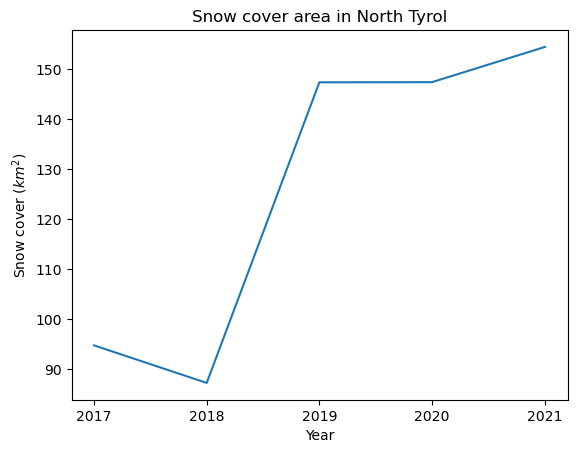

In [5]:
#Time series of snow cover area
fig, ax = plt.subplots()

ax.plot(PSA_year.index, PSA_year.km2_snow);
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator());
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"));

ax.set(title = r'Snow cover area in North Tyrol', xlabel = 'Year', ylabel = 'Snow cover $(km^2)$');

The chart presents the Persistent Snow Cover changes over the period May 2017 - September 2021. Two years with minimum and maximum snow cover can be observed in May 2017 - Sep 2017 and May 2021 - Sep 2021. This short time series doesn't enable us to analyse trends regarding the snowpack evolution or gain insights from the perspective of climate change. However, the dataset allows us to see what is happening at a finer timescale by looking at specific years and identifying years of interest. In the following steps, we will analyse the impact of the topoghraphy on the persistent snow area. 

## Impact of elevation on Persistent Snow Area 

An elevation range between 1500 and 4500 masl was selected with elevation classes defined at 100 m intervals. 

In [6]:
#Aggregate area by elevation and year
PSA_elevation = df_PSA.pivot_table('km2_snow', ['year'], 'elevation_below', aggfunc=sum)
PSA_elevation

elevation_below,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,...,3200,3300,3400,3500,3600,3700,3800,3900,4000,4500
year,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.00,0.00,0.00,0.00,0.04,0.30,0.14,0.07,0.27,0.32,...,18.92,12.56,6.07,2.00,0.33,0.18,0.04,0.0,0.0,0.0
2018-01-01,0.00,0.05,0.01,0.00,0.02,0.01,0.00,0.00,0.17,0.38,...,18.14,11.87,5.44,1.84,0.35,0.13,0.02,0.0,0.0,0.0
2019-01-01,0.00,0.00,0.00,0.03,0.00,0.01,0.01,0.01,0.07,0.11,...,29.70,17.70,7.19,2.36,0.35,0.17,0.01,0.0,0.0,0.0
2020-01-01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.05,...,31.46,19.15,8.11,2.84,0.48,0.23,0.04,0.0,0.0,0.0
2021-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.07,...,32.71,19.97,8.02,2.78,0.49,0.22,0.03,0.0,0.0,0.0


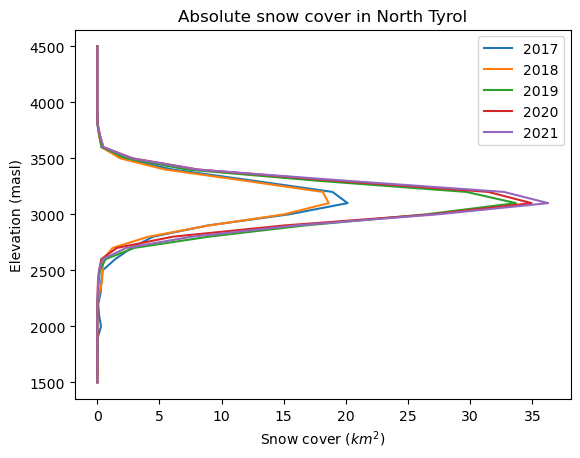

In [7]:
#Absolute snow cover by year and elevation
elevation_below = list(map(float, PSA_elevation.columns))
for row in PSA_elevation.iterrows():
    plt.plot(row[1].values, elevation_below)

plt.title('Absolute snow cover in North Tyrol')
plt.xlabel(r"Snow cover $(km^2)$")
plt.ylabel(r"Elevation (masl)")

plt.legend(['2017','2018', '2019', '2020', '2021'])    
plt.show()

The distribution of PSA lies approximately within the elevation range: 2700 and 3500 masl. Periods of minimum and maximum PSA are also captured in the chart. The largest absolute area of PSA is found at an approximate elevation of 3300 masl.

In [8]:
#Aggregate the sum and count columns to calculate relative snow cover
PSA_elevation_sum = df_PSA.pivot_table(values = ["sum"], index = ['year'], columns = ['elevation_below'], aggfunc=sum)
PSA_elevation_count = df_PSA.pivot_table(values = ["count"], index = ['year'], columns = ['elevation_below'], aggfunc=sum)

#Calculate relative snow cover
PSA_elevation_percent_cover = (PSA_elevation_sum["sum"]/PSA_elevation_count["count"]).fillna(0)

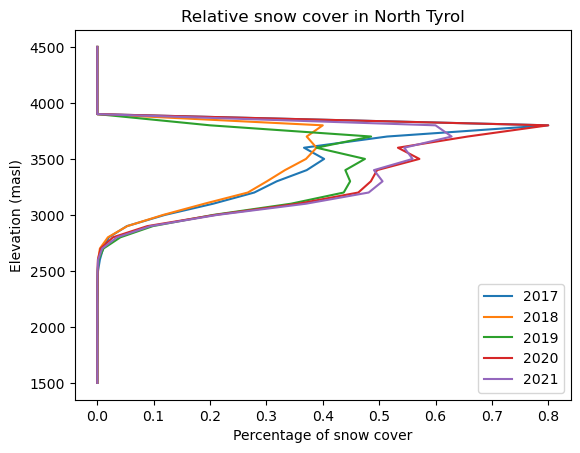

In [9]:
#Relative snow cover by year and elevation

elevation_below = list(map(float, PSA_elevation_percent_cover.columns))
for row in PSA_elevation_percent_cover.iterrows():
    #plt.plot(row[1].values, elevation_below, label=row[1].name)
    plt.plot(row[1].values, elevation_below)

plt.title('Relative snow cover in North Tyrol')
plt.xlabel(r"Percentage of snow cover")
plt.ylabel(r"Elevation (masl)")

plt.legend(['2017','2018', '2019', '2020', '2021'])      
plt.show()

Plotted here is the persistent snow cover relative to the total area in the elevation interal. Here a wider elevation range of persistent snow cover can be observed. Higher elevations would tend to have more persistent snow cover. However, in absolute terms the snow cover at high elevations is not significant (i.e. >3500 masl) because there are not many peaks which reach those altitudes.

## Impact of the aspect on Persistent Snow Area 

For the integration of the aspect in the analysis, the main eight cardinal points were taken. 

In [10]:
#Aggregate area by aspect and year
PSA_aspect = df_PSA.pivot_table('km2_snow', ['year'], 'aspect', aggfunc=sum)
PSA_aspect

aspect,0,45,90,135,180,225,270,315
year,,,,,,,,
2017-01-01,23.49,18.39,11.32,6.49,4.92,4.35,9.46,16.34
2018-01-01,21.79,16.44,10.72,6.47,4.81,4.08,8.51,14.44
2019-01-01,36.38,28.42,17.08,10.50,7.20,6.78,15.23,25.72
2020-01-01,39.50,28.39,16.48,9.06,6.07,5.52,14.32,28.00
2021-01-01,38.81,29.54,17.75,10.49,7.00,6.80,16.12,27.87


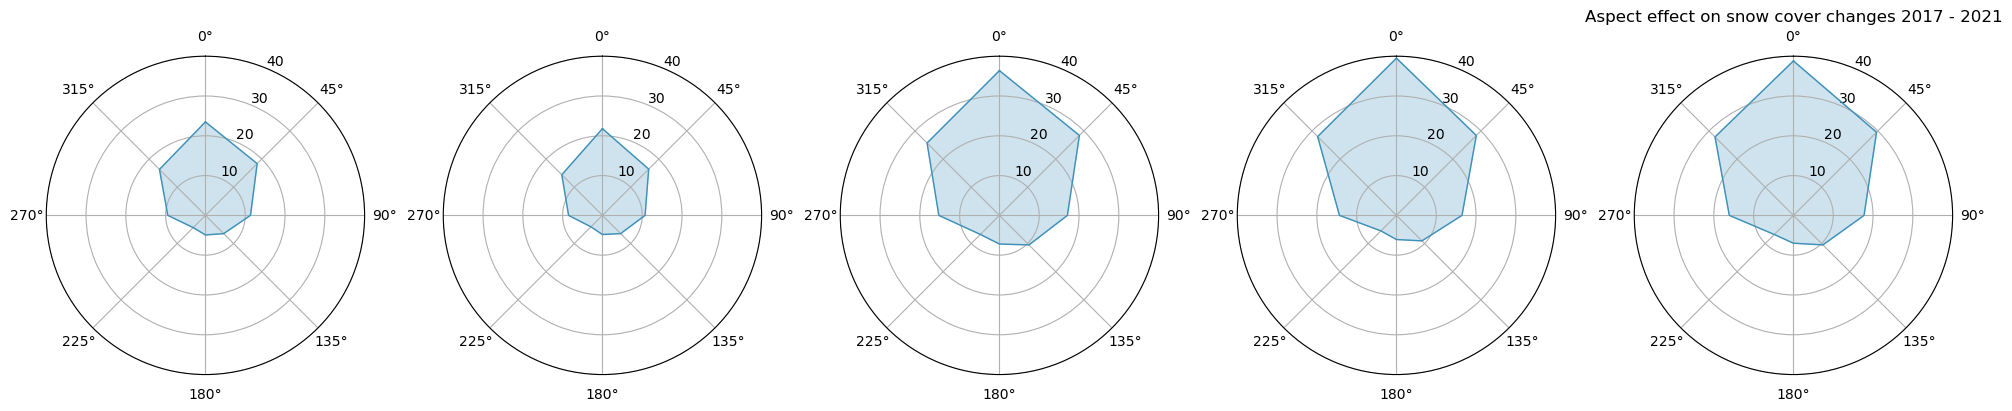

In [11]:
# Define aspect categories
categories=list(PSA_aspect)[0:]

N = len(categories)

# create angle by dividing the plot / number of variable
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=len(PSA_aspect), figsize=(20, 12), 
              subplot_kw=dict(polar=True), dpi = 100)

plt.title('Aspect effect on snow cover changes 2017 - 2021')

fig.tight_layout()

for i in range(len(PSA_aspect)):
    values =  PSA_aspect.loc[PSA_aspect.index[i]].values.flatten().tolist()
    values += values[:1]

     # Draw the outline of the data.
    ax[i].plot(angles, values, color='#3D90B8', linewidth=1, 
          )
    # Fill in the color polygons  
    ax[i].fill(angles, values, color='#3D90B8', alpha=0.25) 

    # Fix axis to go in the right order and start at 12 o'clock.
    ax[i].set_theta_offset(np.pi / 2)
    ax[i].set_theta_direction(-1)

    #set the limits of y axis
    ax[i].set_ylim(0,40)
    ax[i].set_yticks([10,20,30,40])

The aspect patterns are similar accross the years of analysis, with a remarkable Persistent Snow Area in the slopes facing to the North. On the contrary, there is significantly less Persistent Snow Area in the slopes facing to the South.  

In [12]:
#Comparing periods of minimum and maximum extent (2017 - 2018) and (2020 - 2021)
PSA_aspect_2018_2021 = PSA_aspect.iloc[[1, 4]]
PSA_aspect_2018_2021 

aspect,0,45,90,135,180,225,270,315
year,,,,,,,,
2018-01-01,21.79,16.44,10.72,6.47,4.81,4.08,8.51,14.44
2021-01-01,38.81,29.54,17.75,10.49,7.00,6.80,16.12,27.87


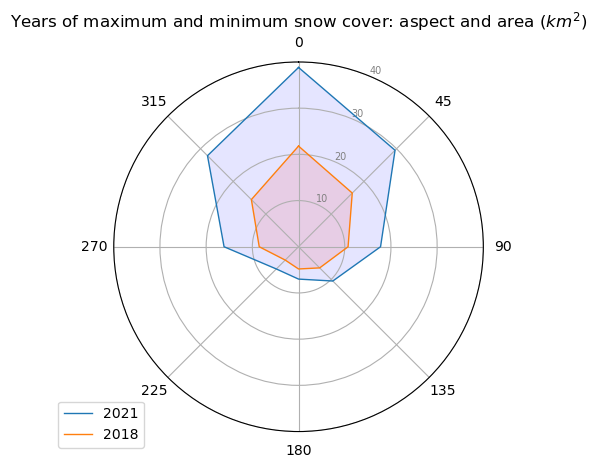

In [13]:
# Define orientation categories
categories=list(PSA_aspect_2018_2021 )[0:]

N = len(categories)

# Create angle by dividing the plot / number of variable
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the polar plot
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)            

#Set the limits of y axis
ax.set_rlabel_position(22.5)
plt.yticks([10,20,30,40], ["10","20","30", "40"], color="grey", size=7)
ax.set_ylim(0,40)

# Add plots
#Period 2020-2021
values=PSA_aspect_2018_2021.loc[PSA_aspect_2018_2021.index[1]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2021")
ax.fill(angles, values, 'b', alpha=0.1) 

# Period 2017 - 2018
values=PSA_aspect_2018_2021.loc[PSA_aspect_2018_2021.index[0]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2018")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.title(r'Years of maximum and minimum snow cover: aspect and area $(km^2)$')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1));
 

The pattern of distribution of snow in the slopes is quite similar among the periods of minimum and maximum persistent snow area. The PSA from the period May 2021 - Sep 2021 more than doubles the extension of PSA in the period May 2018 - Sep 2018. 

## Summary

- Very important to keep extending this dataset because it will keep on gaining value over the years. 
- An aggregation of very large amounts of data were conducted using data cubes to analyse the annual snow cover in North Tyrol.
- PSA dataset provided insights on defining the years with maximum and minimum snow cover over the period of analysis 
- The relative PSA indicates that maximum snow cover is found at around 3300 masl, whereas the absolute snow cover reveals that higher elevations will most likely have more snow cover. 
- Slopes facing to the North have a significant snow cover compared to the slopes facing to the South.
- We obtained a broad perspective identifying the years with minimum and maximum snow cover as well as the general impact of topography, but what is happening at finer time scale? 